# DISCRIMINATOR_STEP = 5 

In [1]:
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

In [2]:
# Import libraries
import os
import xlrd
import math
import zipfile
import numbers
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from pathlib import Path
import time
from ctgan.tablegan import TableganSynthesizer
from ctgan import CTGANSynthesizer
from ctgan import TVAESynthesizer
from sklearn.model_selection import train_test_split

In [3]:
num_epochs = 300

In [4]:
home = str(Path.home())

In [5]:
home

'C:\\Users\\stazt'

In [6]:
# Load cleaned 2016-2018 OVS datasets; replace NAs by -1
OVS1618 = pd.read_csv(home + '/Documents/nBox/Project Ultron/Milestone 3/Dataset/Cleaned (Outliers Removed)/Reduced to Benchmarks-1.csv')

In [7]:
OVS1618.head()

,Expenditure on Accommodation (c4.tot.new),Expenditure on Accommodation (c4.tot.new)_cat,Expenditure on F&B (c6.tot.new),Expenditure on F&B (c6.tot.new)_cat,"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)","Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat",Expenditure on Casual Dining (c6c_2.r),Expenditure on Casual Dining (c6c_2.r)_cat,Expenditure on Transport (c7.tot.new),Expenditure on Transport (c7.tot.new)_cat,...,Mode of Transport (m1),Main POV - Leisure/Holiday (b13a_112),Main POV - Visiting Friends/Family (b13a_114),Main POV - Business (b13a_116),Main POV - Healthcare (b113_117),Main POV - Education/Training/Workshop (b13a_118),Main POV - Others (b13a_119),Travel Package (c1a),"Accommodation - Hotels (c4a_1, c4a_2, c4a_3)","Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)"
0,679.04,0,400.0,0,-1.0,1,400.0,0,50.0,0,...,1,1,0,0,0,0,0,1,1,0
1,-1.00,1,130.0,0,100.0,0,30.0,0,100.0,0,...,1,1,1,0,0,0,0,2,0,0
2,-1.00,1,120.0,0,120.0,0,-1.0,1,40.0,0,...,1,0,0,0,0,0,0,2,0,0
3,-1.00,1,80.0,0,-1.0,1,80.0,0,100.0,0,...,1,1,1,0,0,0,0,2,0,0
4,130.00,0,60.0,0,60.0,0,-1.0,1,40.0,0,...,1,1,0,0,0,0,0,2,0,1


In [8]:
OVS1618.shape

(66030, 38)

In [9]:
# List of 14 expenditure variables
list_expnd = ['Expenditure on Accommodation (c4.tot.new)',
              'Expenditure on F&B (c6.tot.new)',
              'Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)',
              'Expenditure on Casual Dining (c6c_2.r)',
              'Expenditure on Transport (c7.tot.new)', 
              'Expenditure on Sightseeing & Entertainment (c10.tot.new)',
              'Expenditure on Sightseeing (c10c_1.r)',
              'Expenditure on Attractions (c10c_2.r)',
              'Expenditure on Shopping (t7.m.any)',          
              'Expenditure on Healthcare & Wellness Products (t7.m.well)',
              'Expenditure on Confectionery & Food Items (t7.m.food)',
              'Expenditure on Fashion (t7.m.fash)',
              'Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)',
              'Package Expenditure Per Person (c1b.r)']

# List of 10 categorical variables
list_cat = ['Mode of Transport (m1)',
            'Main POV - Leisure/Holiday (b13a_112)',
            'Main POV - Visiting Friends/Family (b13a_114)',
            'Main POV - Business (b13a_116)',
            'Main POV - Healthcare (b113_117)',
            'Main POV - Education/Training/Workshop (b13a_118)',
            'Main POV - Others (b13a_119)',
            'Travel Package (c1a)',
            'Accommodation - Hotels (c4a_1, c4a_2, c4a_3)',
            'Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)']

In [10]:
with open(home + '/Documents/nBox/Project Ultron/Milestone 3/Dataset/Cleaned (Outliers Removed)/binary_categorical_columns.txt',"r+")   as f:
    new_cat_list = f.read().splitlines() 

In [11]:
new_cat_list

['Expenditure on Accommodation (c4.tot.new)_cat',
 'Expenditure on F&B (c6.tot.new)_cat',
 'Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat',
 'Expenditure on Casual Dining (c6c_2.r)_cat',
 'Expenditure on Transport (c7.tot.new)_cat',
 'Expenditure on Sightseeing & Entertainment (c10.tot.new)_cat',
 'Expenditure on Sightseeing (c10c_1.r)_cat',
 'Expenditure on Attractions (c10c_2.r)_cat',
 'Expenditure on Shopping (t7.m.any)_cat',
 'Expenditure on Healthcare & Wellness Products (t7.m.well)_cat',
 'Expenditure on Confectionery & Food Items (t7.m.food)_cat',
 'Expenditure on Fashion (t7.m.fash)_cat',
 'Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)_cat',
 'Package Expenditure Per Person (c1b.r)_cat']

In [12]:
cat_cols = new_cat_list + list_cat

In [13]:
len(cat_cols)

24

In [14]:
## split data into training/validation/test
OVS1618_train_val, OVS1618_test = train_test_split(OVS1618, test_size=0.15, random_state=42)

In [15]:
OVS1618_train_val.shape

(56125, 38)

In [16]:
OVS1618_test.shape

(9905, 38)

# Only first column

In [27]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val['Expenditure on Accommodation (c4.tot.new)'], epochs=300, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of Epochs:  300
training data shape:  (46247,)
validation data shape:  (9878,)
num_components 11
transformed data shape:  (46247, 12)
data dimension: 12
Dropout rate:  0.5
Epoch 1, Loss G: 1.4003, Loss D: -0.8628
Epoch 2, Loss G: 1.4723, Loss D: -1.0303
Epoch 3, Loss G: 1.5098, Loss D: -1.4558
Epoch 4, Loss G: 1.5540, Loss D: -1.9259
Epoch 5, Loss G: 1.5341, Loss D: -1.9254
Epoch 6, Loss G: 1.5224, Loss D: -2.0833
Epoch 7, Loss G: 1.5465, Loss D: -2.4509
Epoch 8, Loss G: 1.5408, Loss D: -2.8654
Epoch 9, Loss G: 1.5005, Loss D: -2.9933
Epoch 10, Loss G: 1.5232, Loss D: -3.3287
Epoch 11, Loss G: 1.4860, Loss D: -3.7668
Epoch 12, Loss G: 1.5052, Loss D: -3.9006
Epoch 13, Loss G: 1.4817, Loss D: -4.3194
Epoch 14, Loss G: 1.5292, Loss D: -4.6221
Epoch 15, Loss G: 1.4815, Loss D: -5.0718
Epoch 16, Loss G: 1.5089, Loss D: -5.3839
Epoch 17, Loss G: 1.5038, Loss D: -5.5697
Epoch 18, Loss G: 1.5310, Loss D: -6.4495
Epoch 1

Epoch 185, Loss G: 2.0931, Loss D: -14.7176
Epoch 186, Loss G: 2.0963, Loss D: -14.9287
Epoch 187, Loss G: 2.0581, Loss D: -15.2129
Epoch 188, Loss G: 2.1036, Loss D: -15.6179
Epoch 189, Loss G: 2.0939, Loss D: -16.3514
Epoch 190, Loss G: 2.0644, Loss D: -15.6819
Epoch 191, Loss G: 2.0973, Loss D: -16.3551
Epoch 192, Loss G: 2.0506, Loss D: -15.5513
Epoch 193, Loss G: 2.0539, Loss D: -15.9773
Epoch 194, Loss G: 2.0933, Loss D: -16.7072
Epoch 195, Loss G: 2.0743, Loss D: -16.7143
Epoch 196, Loss G: 2.0695, Loss D: -17.4488
Epoch 197, Loss G: 2.1158, Loss D: -16.7146
Epoch 198, Loss G: 2.1696, Loss D: -17.2430
Epoch 199, Loss G: 2.1233, Loss D: -17.6417
Epoch 200, Loss G: 2.1492, Loss D: -17.1781
Epoch 201, Loss G: 2.1992, Loss D: -17.8770
Epoch 202, Loss G: 2.1961, Loss D: -18.4278
Epoch 203, Loss G: 2.1580, Loss D: -18.8428
Epoch 204, Loss G: 2.1855, Loss D: -18.8474
Epoch 205, Loss G: 2.2428, Loss D: -19.1268
Epoch 206, Loss G: 2.2110, Loss D: -18.4569
Epoch 207, Loss G: 2.1833, Loss 

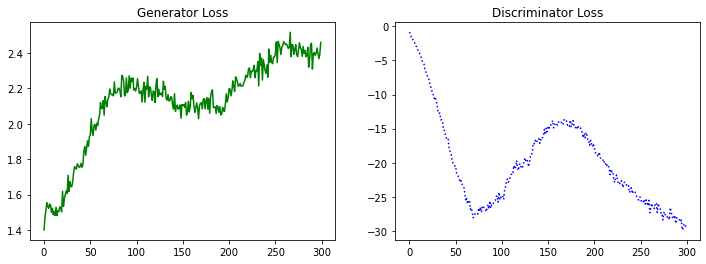

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(ctgan.generator_loss,'-g')
ax[0].set_title('Generator Loss')

ax[1].plot(ctgan.discriminator_loss,':b')
ax[1].set_title('Discriminator Loss');

## First Five continuous columns

In [19]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val[list_expnd[0:5]], epochs=300, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of Epochs:  300
training data shape:  (46247, 5)
validation data shape:  (9878, 5)
num_components 11
num_components 14
num_components 14
num_components 14
num_components 14
transformed data shape:  (46247, 72)
data dimension: 72
Dropout rate:  0.5
Epoch 1, Loss G: 1.1765, Loss D: -1.5186
Epoch 2, Loss G: 1.6288, Loss D: -1.7390
Epoch 3, Loss G: 2.0523, Loss D: -2.2525
Epoch 4, Loss G: 2.1194, Loss D: -2.8825
Epoch 5, Loss G: 2.2026, Loss D: -4.1071
Epoch 6, Loss G: 2.3770, Loss D: -4.8196
Epoch 7, Loss G: 2.5249, Loss D: -5.9968
Epoch 8, Loss G: 2.6290, Loss D: -7.0328
Epoch 9, Loss G: 2.7491, Loss D: -8.7478
Epoch 10, Loss G: 2.8388, Loss D: -9.6580
Epoch 11, Loss G: 2.9112, Loss D: -10.7191
Epoch 12, Loss G: 3.0038, Loss D: -11.9405
Epoch 13, Loss G: 2.9471, Loss D: -12.8423
Epoch 14, Loss G: 3.0101, Loss D: -13.9032
Epoch 15, Loss G: 3.1153, Loss D: -15.1481
Epoch 16, Loss G: 3.1819, Loss D: -16.3580
Epoch 17,

Epoch 183, Loss G: 5.7508, Loss D: -101.6897
Epoch 184, Loss G: 5.7795, Loss D: -105.0112
Epoch 185, Loss G: 5.8648, Loss D: -101.8773
Epoch 186, Loss G: 5.7761, Loss D: -100.6870
Epoch 187, Loss G: 5.8213, Loss D: -101.2983
Epoch 188, Loss G: 5.6683, Loss D: -99.5855
Epoch 189, Loss G: 5.7913, Loss D: -105.1155
Epoch 190, Loss G: 5.8291, Loss D: -100.9186
Epoch 191, Loss G: 5.9811, Loss D: -105.7152
Epoch 192, Loss G: 6.0354, Loss D: -105.8896
Epoch 193, Loss G: 6.0309, Loss D: -105.0988
Epoch 194, Loss G: 5.8765, Loss D: -108.4732
Epoch 195, Loss G: 5.9397, Loss D: -105.3427
Epoch 196, Loss G: 5.8820, Loss D: -103.8099
Epoch 197, Loss G: 6.1145, Loss D: -106.2646
Epoch 198, Loss G: 5.8641, Loss D: -104.4099
Epoch 199, Loss G: 5.9137, Loss D: -104.8676
Epoch 200, Loss G: 5.7879, Loss D: -102.8909
Epoch 201, Loss G: 5.8788, Loss D: -101.3177
Epoch 202, Loss G: 5.8019, Loss D: -105.0800
Epoch 203, Loss G: 5.7980, Loss D: -105.5929
Epoch 204, Loss G: 5.6677, Loss D: -104.0181
Epoch 205, 

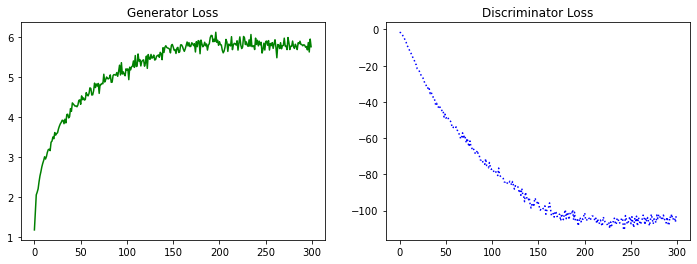

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(ctgan.generator_loss,'-g')
ax[0].set_title('Generator Loss')

ax[1].plot(ctgan.discriminator_loss,':b')
ax[1].set_title('Discriminator Loss');

# First Five categorical columns

In [21]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val[cat_cols[0:5]], discrete_columns=cat_cols[0:5], epochs=300, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of Epochs:  300
training data shape:  (46247, 5)
validation data shape:  (9878, 5)
transformed data shape:  (46247, 10)
data dimension: 10
Dropout rate:  0.5
Epoch 1, Loss G: 0.3000, Loss D: -0.4743
Epoch 2, Loss G: -0.1206, Loss D: -0.6228
Epoch 3, Loss G: -0.7560, Loss D: -0.5300
Epoch 4, Loss G: -0.6624, Loss D: -0.4626
Epoch 5, Loss G: -0.3623, Loss D: -0.1939
Epoch 6, Loss G: -0.1053, Loss D: -0.2523
Epoch 7, Loss G: -0.0921, Loss D: -0.0925
Epoch 8, Loss G: -0.1961, Loss D: -0.0539
Epoch 9, Loss G: -0.2061, Loss D: -0.0050
Epoch 10, Loss G: -0.6093, Loss D: -0.4953
Epoch 11, Loss G: -0.3028, Loss D: -0.3188
Epoch 12, Loss G: -0.6699, Loss D: 0.0337
Epoch 13, Loss G: -0.4029, Loss D: 0.0036
Epoch 14, Loss G: -0.2556, Loss D: 0.1025
Epoch 15, Loss G: -0.2582, Loss D: -0.1460
Epoch 16, Loss G: -0.6218, Loss D: -0.0852
Epoch 17, Loss G: -0.4279, Loss D: -0.3231
Epoch 18, Loss G: -0.8278, Loss D: -0.1200
Epoch 1

Epoch 187, Loss G: -1.0306, Loss D: -0.1295
Epoch 188, Loss G: -0.5920, Loss D: 0.2937
Epoch 189, Loss G: -0.8170, Loss D: 0.0114
Epoch 190, Loss G: -0.7370, Loss D: -0.1419
Epoch 191, Loss G: -0.5368, Loss D: 0.0150
Epoch 192, Loss G: -0.8095, Loss D: -0.2434
Epoch 193, Loss G: -0.9284, Loss D: 0.1191
Epoch 194, Loss G: -0.7378, Loss D: 0.0308
Epoch 195, Loss G: -1.1720, Loss D: -0.0956
Epoch 196, Loss G: -0.6376, Loss D: -0.2455
Epoch 197, Loss G: -0.5518, Loss D: -0.3020
Epoch 198, Loss G: -0.9164, Loss D: 0.0286
Epoch 199, Loss G: -0.9497, Loss D: 0.0234
Epoch 200, Loss G: -0.6699, Loss D: -0.1268
Epoch 201, Loss G: -0.5507, Loss D: 0.0668
Epoch 202, Loss G: -0.8712, Loss D: 0.5098
Epoch 203, Loss G: -0.9830, Loss D: 0.0384
Epoch 204, Loss G: -0.4239, Loss D: 0.1773
Epoch 205, Loss G: -1.1581, Loss D: -0.3921
Epoch 206, Loss G: -1.0938, Loss D: 0.1047
Epoch 207, Loss G: -1.1914, Loss D: -0.1360
Epoch 208, Loss G: -1.0151, Loss D: -0.3442
Epoch 209, Loss G: -1.0445, Loss D: -0.1386


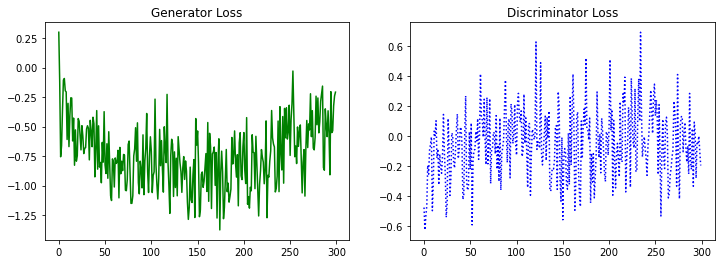

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(ctgan.generator_loss,'-g')
ax[0].set_title('Generator Loss')

ax[1].plot(ctgan.discriminator_loss,':b')
ax[1].set_title('Discriminator Loss');

# First five columns

In [23]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val[OVS1618_train_val.columns[0:5]], discrete_columns=cat_cols[0:2],epochs=300, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of Epochs:  300
training data shape:  (46247, 5)
validation data shape:  (9878, 5)
num_components 13
num_components 14
num_components 14
transformed data shape:  (46247, 48)
data dimension: 48
Dropout rate:  0.5
Epoch 1, Loss G: 0.2344, Loss D: -0.2102
Epoch 2, Loss G: 0.3870, Loss D: -0.4943
Epoch 3, Loss G: 0.1533, Loss D: -0.5844
Epoch 4, Loss G: 0.0229, Loss D: -0.6281
Epoch 5, Loss G: -0.2854, Loss D: -0.3232
Epoch 6, Loss G: 0.0623, Loss D: -0.4121
Epoch 7, Loss G: -0.0017, Loss D: -0.4291
Epoch 8, Loss G: -0.2751, Loss D: -0.3086
Epoch 9, Loss G: -0.3399, Loss D: -0.2812
Epoch 10, Loss G: -0.3502, Loss D: -0.5572
Epoch 11, Loss G: -0.6514, Loss D: -0.4465
Epoch 12, Loss G: -0.2759, Loss D: -0.3404
Epoch 13, Loss G: -0.4090, Loss D: -0.5921
Epoch 14, Loss G: -0.4507, Loss D: -0.3323
Epoch 15, Loss G: -0.4986, Loss D: -0.4779
Epoch 16, Loss G: -0.1211, Loss D: -0.3785
Epoch 17, Loss G: -0.2349, Loss D: -0.24

Epoch 184, Loss G: -0.3075, Loss D: -0.1949
Epoch 185, Loss G: -0.5461, Loss D: -0.1331
Epoch 186, Loss G: -0.4166, Loss D: -0.1001
Epoch 187, Loss G: -0.5742, Loss D: -0.1042
Epoch 188, Loss G: -0.4409, Loss D: -0.0940
Epoch 189, Loss G: -0.3154, Loss D: -0.0556
Epoch 190, Loss G: -0.3204, Loss D: -0.1705
Epoch 191, Loss G: -0.4862, Loss D: -0.2219
Epoch 192, Loss G: -0.3166, Loss D: -0.1296
Epoch 193, Loss G: -0.4467, Loss D: -0.0974
Epoch 194, Loss G: -0.3840, Loss D: -0.0750
Epoch 195, Loss G: -0.4501, Loss D: -0.0673
Epoch 196, Loss G: -0.5888, Loss D: -0.0543
Epoch 197, Loss G: -0.3444, Loss D: -0.2064
Epoch 198, Loss G: -0.5424, Loss D: 0.0223
Epoch 199, Loss G: -0.4953, Loss D: -0.0931
Epoch 200, Loss G: -0.4386, Loss D: -0.0855
Epoch 201, Loss G: -0.4754, Loss D: -0.1231
Epoch 202, Loss G: -0.3982, Loss D: -0.1063
Epoch 203, Loss G: -0.5060, Loss D: -0.1438
Epoch 204, Loss G: -0.5450, Loss D: -0.1995
Epoch 205, Loss G: -0.2383, Loss D: 0.1036
Epoch 206, Loss G: -0.5782, Loss D

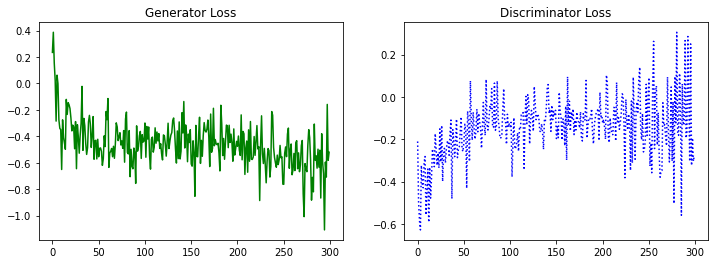

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(ctgan.generator_loss,'-g')
ax[0].set_title('Generator Loss')

ax[1].plot(ctgan.discriminator_loss,':b')
ax[1].set_title('Discriminator Loss');

# all benchmark variables

In [25]:
ctgan = CTGANSynthesizer()
print('Training CTGAN is starting')
start_time = time.time()
ctgan.fit(OVS1618_train_val, discrete_columns=cat_cols, epochs=300, model_summary=False, trans="VGM",use_cond_gen=True)
elapsed_time = time.time() - start_time

Training CTGAN is starting
Learning rate:  0.0002
Batch size:  500
Number of Epochs:  300
training data shape:  (46247, 38)
validation data shape:  (9878, 38)
num_components 12
num_components 12
num_components 15
num_components 14
num_components 14
num_components 11
num_components 10
num_components 14
num_components 14
num_components 10
num_components 13
num_components 11
num_components 11
num_components 8
transformed data shape:  (46247, 232)
data dimension: 232
Dropout rate:  0.5
Epoch 1, Loss G: -0.7576, Loss D: -0.3334
Epoch 2, Loss G: 0.0283, Loss D: -1.0628
Epoch 3, Loss G: 0.5478, Loss D: -1.1683
Epoch 4, Loss G: -0.5519, Loss D: -0.7152
Epoch 5, Loss G: -2.3934, Loss D: -0.7300
Epoch 6, Loss G: -1.5909, Loss D: 0.4682
Epoch 7, Loss G: -1.0669, Loss D: -1.6372
Epoch 8, Loss G: -0.3882, Loss D: -0.8968
Epoch 9, Loss G: -1.5876, Loss D: -0.5939
Epoch 10, Loss G: -1.1823, Loss D: 0.0381
Epoch 11, Loss G: -1.3682, Loss D: -0.5439
Epoch 12, Loss G: -0.5748, Loss D: -0.4378
Epoch 13, 

Epoch 180, Loss G: -1.3286, Loss D: -0.8534
Epoch 181, Loss G: -1.6392, Loss D: -0.5011
Epoch 182, Loss G: -1.9638, Loss D: 0.0584
Epoch 183, Loss G: -1.3837, Loss D: -0.3238
Epoch 184, Loss G: -0.9282, Loss D: -0.8419
Epoch 185, Loss G: -1.7585, Loss D: -0.6590
Epoch 186, Loss G: -1.0802, Loss D: -0.4877
Epoch 187, Loss G: -1.6144, Loss D: -0.3828
Epoch 188, Loss G: -1.6453, Loss D: -0.8107
Epoch 189, Loss G: -1.2057, Loss D: -0.2641
Epoch 190, Loss G: -1.4403, Loss D: -0.3391
Epoch 191, Loss G: -1.8267, Loss D: 0.0897
Epoch 192, Loss G: -0.5536, Loss D: -0.2577
Epoch 193, Loss G: -1.0777, Loss D: 0.1139
Epoch 194, Loss G: -0.6725, Loss D: -0.2341
Epoch 195, Loss G: -2.0784, Loss D: -0.2547
Epoch 196, Loss G: -2.0361, Loss D: -0.7080
Epoch 197, Loss G: -1.6897, Loss D: -0.1105
Epoch 198, Loss G: -1.2092, Loss D: -0.2251
Epoch 199, Loss G: -1.7021, Loss D: -0.3897
Epoch 200, Loss G: -0.8375, Loss D: 0.0665
Epoch 201, Loss G: -2.1993, Loss D: -0.4463
Epoch 202, Loss G: -1.4445, Loss D: 

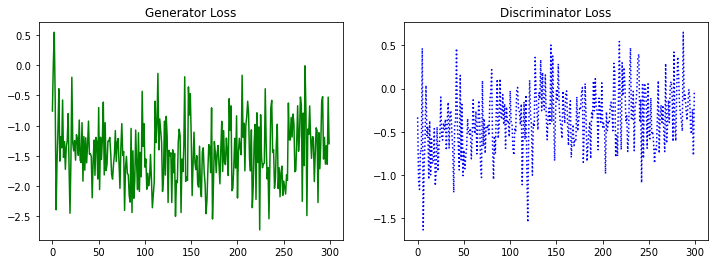

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(ctgan.generator_loss,'-g')
ax[0].set_title('Generator Loss')

ax[1].plot(ctgan.discriminator_loss,':b')
ax[1].set_title('Discriminator Loss');